# PRANA: A contact tracing algorithm using DBSCAN algorithm

This notebook is an attempt to develop a contact tracing algorithm using DBSCAN.  
Detailed explanation of this notebook is available in my Medium article: https://medium.com/swlh/building-a-simple-contact-tracing-model-using-the-dbscan-algorithm-5ea796d7afdc

## Step 1: Importing libraries and the data

We will be using libraries like Pandas for data manipulation, Scikit-learn for machine learning, Matplotlib, and Seaborn for data visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.cluster import DBSCAN

The training dataset is a time-series of location history of people with a name in the form of JSON array. The each JSON object consists of the name of the person, latitude, longitude along with the timestamp.

Although timestamp is present, the current version of the model does not use it, yet.

**Note:** To read our training dataset, we use pandas. Make sure that the type of latitude and longitude are in float64 format, and not string.

In [2]:
df = pd.read_json('./testdata/train_dataset.json')

To get the concise summary of the DataFrame which prints information about the DataFrame including the index dtype, column dtypes, non-null values, and memory usage, we use:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         241 non-null    object        
 1   timestamp  241 non-null    datetime64[ns]
 2   latitude   241 non-null    float64       
 3   longitude  241 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 7.7+ KB


To get the descriptive statistics including those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values, we use:

In [4]:
df.describe()

,latitude,longitude
count,241.000000,241.000000
mean,12.969013,77.624182
std,0.054117,0.106017
min,12.880172,77.445770
25%,12.924060,77.532829
50%,12.969007,77.623604
75%,13.010509,77.712913
max,13.068818,77.797501


Let us return the first 5 rows to check if the object has the right type of data in it:

In [5]:
df.head()

,id,timestamp,latitude,longitude
0,Alice,2020-06-28 19:52:26,12.880172,77.784798
1,Alice,2020-06-28 20:52:26,12.993111,77.596512
2,Alice,2020-06-28 21:52:26,12.975756,77.463615
3,Alice,2020-06-28 22:52:26,12.974606,77.615150
4,Alice,2020-06-28 23:52:26,12.997514,77.706261


Checking the unique names in the id column:

In [6]:
df['id'].unique()

array(['Alice', 'Bob', 'Carol', 'David', 'Erin', 'Frank', 'Grace',
       'Heidi', 'Ivan', 'Judy'], dtype=object)

## Step 2: EDA (Exploratory data analysis)

Let us analyze the dataset using the Scatter plot showing the ids with their latitudes and longitudes across the x-axis and y-axis respectively.

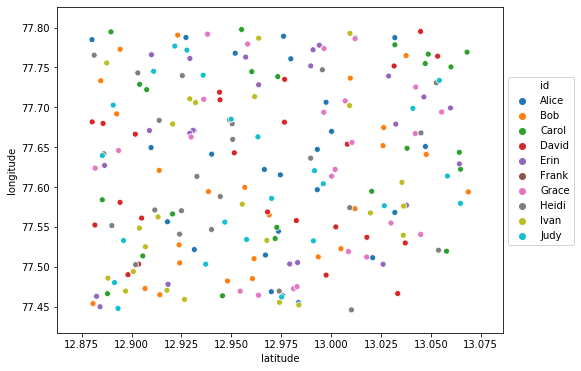

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='latitude', y='longitude', data=df, hue='id')
plt.legend(bbox_to_anchor= [1, 0.8])

Let us analyze the same dataset using a joint plot as shown below:

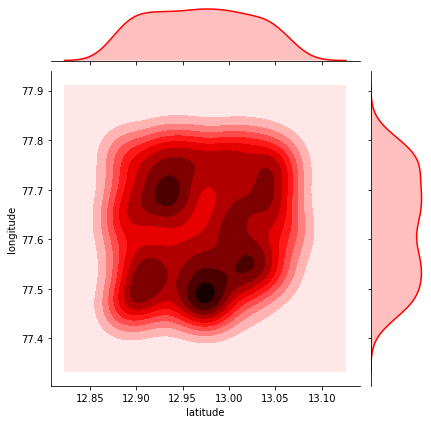

In [8]:
sns.jointplot(x='latitude', y='longitude', data=df, color='red', kind='kde')


Let us now use the box plot to visualize the distribution of ids and latitudes in the x-axis and y-axis respectively.

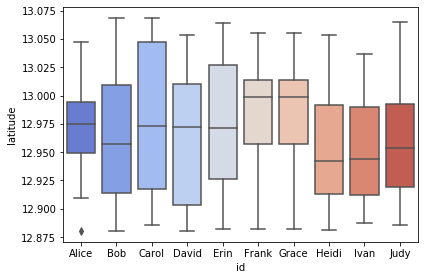

In [9]:
sns.boxplot(x='id', y= 'latitude', data = df, palette = 'coolwarm')
plt.tight_layout()

Similarly, we’ll plot to visualize the distribution of ids and longitudes in the x-axis and y-axis respectively.

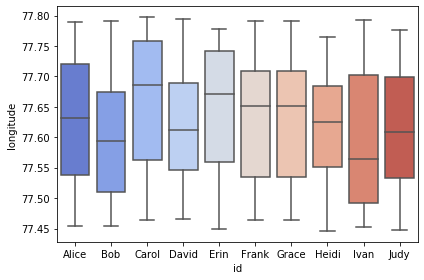

In [10]:
sns.boxplot(x='id',y='longitude',data=df, palette='coolwarm')
plt.tight_layout()

## Step 3: Defining the model

The code block below shows the creation of a model, using the model to generate clusters, and identifying the infections by filtering the data in the clusters. As you can see from the code block below, we are defining the model using DBSCAN algorithm.

In [11]:
epsilon = 0.0018288 # a radial distance of 6 feet in kilometers
model = DBSCAN(eps = epsilon, min_samples = 2, metric = 'haversine').fit(df[['latitude', 'longitude']])
df['cluster'] = model.labels_.tolist()

For my dataset, the model was able to generate 29 clusters, out of which cluster-0 to cluster-28 represents data points with neighboring nodes.

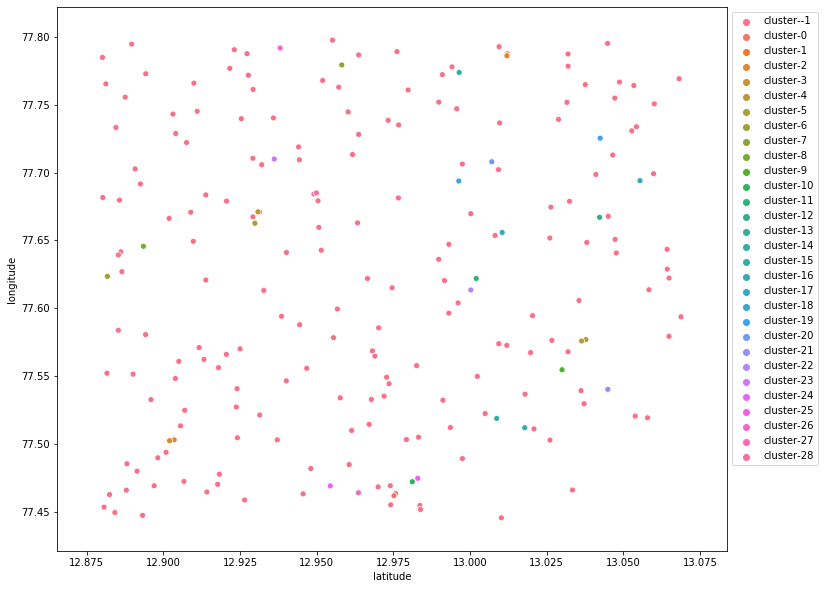

In [12]:
labels = model.labels_
fig = plt.figure(figsize=(12,10))
sns.scatterplot(df['latitude'], df['longitude'], hue = ['cluster-{}'.format(x) for x in labels])
plt.legend(bbox_to_anchor = [1, 1])

The cluster -1 from the above plot represents noise. We’ll go ahead and plot the same but without the noise.

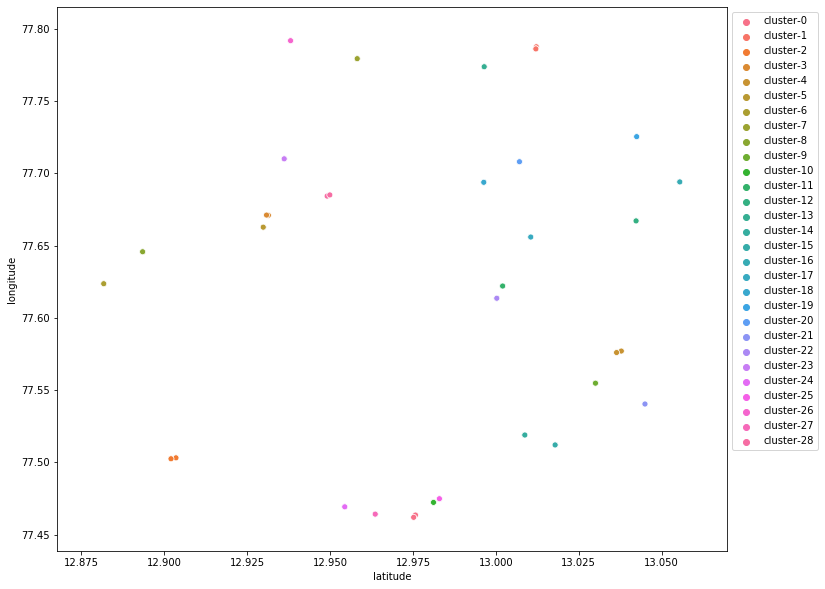

In [13]:
ids = df[(df['cluster'] == -1)].index
df.drop(ids, inplace = True)
labels = model.labels_
fig = plt.figure(figsize=(12,10))
sns.scatterplot(df['latitude'], df['longitude'], hue = ['cluster-{}'.format(x) for x in df['cluster']])
plt.legend(bbox_to_anchor = [1, 1])

## Step 4: Testing the model

**Identifying infected people:**

To check for the people who might be potentially infected from the patient, we’ll simply call the function `get_infected_names` and input a name from the dataset as a parameter. The function is defined as follows:

In [14]:
def get_infected_names(input_name):
    df = pd.read_json('./testdata/train_dataset.json')
    epsilon = 0.0018288 # a radial distance of 6 feet in kilometers
    model = DBSCAN(eps=epsilon, min_samples=2, metric='haversine').fit(df[['latitude', 'longitude']])
    df['cluster'] = model.labels_.tolist()

    input_name_clusters = []
    for i in range(len(df)):
        if df['id'][i] == input_name:
            if df['cluster'][i] in input_name_clusters:
                pass
            else:
                input_name_clusters.append(df['cluster'][i])
    
    infected_names = []
    for cluster in input_name_clusters:
        if cluster != -1:
            ids_in_cluster = df.loc[df['cluster'] == cluster, 'id']
            for i in range(len(ids_in_cluster)):
                member_id = ids_in_cluster.iloc[i]
                if (member_id not in infected_names) and (member_id != input_name):
                    infected_names.append(member_id)
                else:
                    pass
    return infected_names

**Below function calls shows the results of potentially infected people names.**

In [15]:
get_infected_names('Alice')

['Judy']

In [16]:
get_infected_names('Erin')

['Ivan']

In [17]:
get_infected_names('David')

['Heidi']

In [18]:
get_infected_names('Judy')

['Heidi', 'Alice']

In [19]:
get_infected_names('Ivan')

['Erin']

In [20]:
get_infected_names('Heidi')

['David', 'Judy']